In [30]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CIFAR10
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torchsummary import summary
import albumentations as A
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from albumentations.pytorch import ToTensorV2


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # if self.downsample is not None:
        #     identity = self.downsample(x)

        #out += identity
        out = self.relu(out)

        return out


class ResNetEncoder(nn.Module):
    def __init__(self, block, layers, num_classes, use_global_pooling=True):
        super(ResNetEncoder, self).__init__()
        self.in_channels = 3
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # self.bn1 = nn.BatchNorm2d(64)
        # self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layers = nn.ModuleList()
        for i, layer_blocks in enumerate(layers):
            stride = 2 if i > 0 else 1
            res_block = self.make_layer(block, 64 * (2 ** i), layer_blocks, stride)
            self.layers.append(res_block)

        self.use_global_pooling = use_global_pooling

        if use_global_pooling:
            self.global_pool = nn.AdaptiveAvgPool2d(1)

        fc_input_size = 64 * (2 ** (len(layers) - 1))
        
        if not use_global_pooling:
            fc_input_size *= 4*4
        self.fc = nn.Linear(fc_input_size, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        # if stride != 1 or self.in_channels != out_channels:
        #     downsample = nn.Sequential(
        #         nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        #         nn.BatchNorm2d(out_channels),
        #     )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # x = self.conv1(x)
        # x = self.bn1(x)
        # x = self.relu(x)
        # x = self.maxpool(x)

        for layer in self.layers:
            x = layer(x)

        if self.use_global_pooling:
            x = self.global_pool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def train_model(self, train_dataset, val_dataset, learning_rate=0.001, batch_size=32, epochs=20, patience_stop=4):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        criterion = nn.CrossEntropyLoss()

        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

        best_val_loss = float('inf')
        best_val_accuracy = 0.0
        best_model_state = None
        patience_counter = 0

        training_results = {'train_accuracy': [], 'train_loss': [], 'val_accuracy': [], 'val_loss': []}

        for epoch in range(epochs):
            self.train()
            total_loss = 0
            correct_predictions = 0
            total_samples = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)

                # Applying weight decay
                for param in self.parameters():
                    loss += 1e-4 * torch.norm(param)

                loss.backward()

                # Gradient clipping to avoid exploding gradients
                nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)

                optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            average_loss = total_loss / len(train_loader)
            accuracy = correct_predictions / total_samples * 100.0
            training_results['train_accuracy'].append(accuracy)
            training_results['train_loss'].append(average_loss)

            # Validation
            self.eval()
            val_loss = 0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)
                    val_loss += criterion(outputs, labels).item()
                    _, predicted = torch.max(outputs, 1)
                    val_correct_predictions += (predicted == labels).sum().item()
                    val_total_samples += labels.size(0)

            val_average_loss = val_loss / len(val_loader)
            val_accuracy = val_correct_predictions / val_total_samples * 100.0
            training_results['val_accuracy'].append(val_accuracy)
            training_results['val_loss'].append(val_average_loss)

            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy:.2f}%, "
                f"Val Loss: {val_average_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

            # Learning rate scheduling based on validation loss
            scheduler.step(val_average_loss)

            # Update best validation accuracy and model state
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model_state = self.state_dict()

            # Early stopping based on validation loss
            if val_average_loss < best_val_loss:
                best_val_loss = val_average_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience_stop:
                print(f"Early stopping at epoch {epoch + 1} as validation loss didn't improve for {patience} epochs.")
                break

        # Restore the model state with the best validation accuracy
        if best_model_state is not None:
            self.load_state_dict(best_model_state)

        return training_results

    def test_model(self, test_dataset, batch_size):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

        self.eval()

        correct_predictions = 0
        total_samples = 0

        test_results = {'test_accuracy': []}
        confusion_labels = []
        confusion_predictions = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)

                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

                confusion_labels.extend(labels.cpu().numpy())
                confusion_predictions.extend(predicted.cpu().numpy())

        # Calculate and store test accuracy
        test_accuracy = correct_predictions / total_samples * 100.0
        test_results['test_accuracy'].append(test_accuracy)

        # Generate and plot the confusion matrix
        confusion_mat = confusion_matrix(confusion_labels, confusion_predictions)
        class_names = [f'Class {i}' for i in range(10)]

        plt.figure(figsize=(5, 5))
        sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        return test_results

/tmp/ipykernel_62868/3387227823.py:5: DeprecationWarning: Initializing with 'size' as an integer and a separate 'width' is deprecated. Please use a tuple (height, width) for the 'size' argument.
  A.RandomResizedCrop(32, 32, scale=(0.8, 1.0), ratio=(0.75, 1.333)),


Files already downloaded and verified
Epoch 1/30, Train Loss: 1.5308, Train Accuracy: 44.80%, Val Loss: 1.2074, Val Accuracy: 56.51%
Epoch 2/30, Train Loss: 1.1448, Train Accuracy: 59.37%, Val Loss: 1.0435, Val Accuracy: 62.99%
Epoch 3/30, Train Loss: 0.9526, Train Accuracy: 67.48%, Val Loss: 0.9100, Val Accuracy: 68.10%
Epoch 4/30, Train Loss: 0.8497, Train Accuracy: 70.97%, Val Loss: 0.7947, Val Accuracy: 72.57%
Epoch 5/30, Train Loss: 0.7771, Train Accuracy: 73.83%, Val Loss: 0.7254, Val Accuracy: 74.55%
Epoch 6/30, Train Loss: 0.7142, Train Accuracy: 76.12%, Val Loss: 0.8429, Val Accuracy: 71.00%
Epoch 7/30, Train Loss: 0.6694, Train Accuracy: 77.64%, Val Loss: 0.7283, Val Accuracy: 75.39%
Epoch 8/30, Train Loss: 0.6398, Train Accuracy: 78.34%, Val Loss: 0.6586, Val Accuracy: 77.18%
Epoch 9/30, Train Loss: 0.6077, Train Accuracy: 79.78%, Val Loss: 0.6411, Val Accuracy: 78.01%
Epoch 10/30, Train Loss: 0.5902, Train Accuracy: 80.46%, Val Loss: 0.5861, Val Accuracy: 79.81%
Epoch 11/30

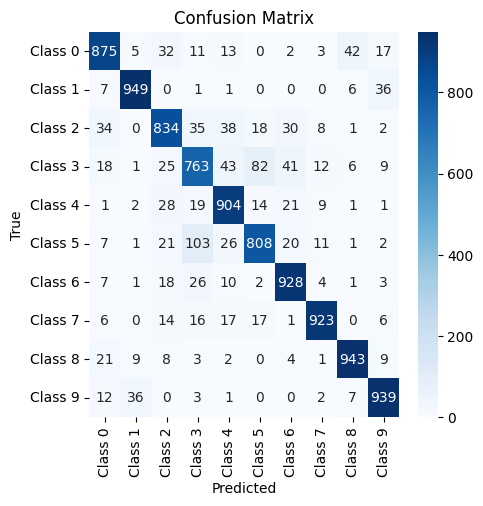

Test Accuracy: 88.66%


In [14]:
# Define albumentations transformations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.RandomResizedCrop(32, 32, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize to [-1, 1]
])
# Load CIFAR-10 dataset with albumentations transformations
trainset = CIFAR10(root='./data', train=True, download=True, transform=None)
trainset.transform = lambda img: transform(image=np.array(img))['image']


# Split dataset into train and validation
val_split = 0.2
train_size = len(trainset)
indices = list(range(train_size))
split = int(np.floor(val_split * train_size))
np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

train_subset = Subset(trainset, train_idx)
val_subset = Subset(trainset, val_idx)

# Instantiate ResNet model
resnet = ResNetEncoder(BasicBlock, [1,1,1,1], num_classes=10, use_global_pooling=True)

# Train the model
training_results = resnet.train_model(train_subset, val_subset, learning_rate=0.001, batch_size=32, epochs=30)

# Test the model
testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_results = resnet.test_model(testset, batch_size=32)

# Print test accuracy
print(f"Test Accuracy: {test_results['test_accuracy'][0]:.2f}%")

/tmp/ipykernel_62868/1192247552.py:5: DeprecationWarning: Initializing with 'size' as an integer and a separate 'width' is deprecated. Please use a tuple (height, width) for the 'size' argument.
  A.RandomResizedCrop(32, 32, scale=(0.8, 1.0), ratio=(0.75, 1.333)),


Files already downloaded and verified
Epoch 1/30, Train Loss: 1.6552, Train Accuracy: 43.59%, Val Loss: 1.3354, Val Accuracy: 52.04%
Epoch 2/30, Train Loss: 1.2934, Train Accuracy: 55.16%, Val Loss: 1.1495, Val Accuracy: 59.04%
Epoch 3/30, Train Loss: 1.1161, Train Accuracy: 61.39%, Val Loss: 1.0494, Val Accuracy: 62.82%
Epoch 4/30, Train Loss: 0.9835, Train Accuracy: 66.19%, Val Loss: 0.9291, Val Accuracy: 67.07%
Epoch 5/30, Train Loss: 0.8718, Train Accuracy: 70.26%, Val Loss: 0.8490, Val Accuracy: 70.09%
Epoch 6/30, Train Loss: 0.7991, Train Accuracy: 72.91%, Val Loss: 0.8176, Val Accuracy: 71.57%
Epoch 7/30, Train Loss: 0.7407, Train Accuracy: 74.88%, Val Loss: 0.7176, Val Accuracy: 74.51%
Epoch 8/30, Train Loss: 0.7075, Train Accuracy: 76.09%, Val Loss: 0.6960, Val Accuracy: 76.38%
Epoch 9/30, Train Loss: 0.6633, Train Accuracy: 77.82%, Val Loss: 0.7336, Val Accuracy: 75.33%
Epoch 10/30, Train Loss: 0.6339, Train Accuracy: 78.63%, Val Loss: 0.7829, Val Accuracy: 73.70%
Epoch 11/30

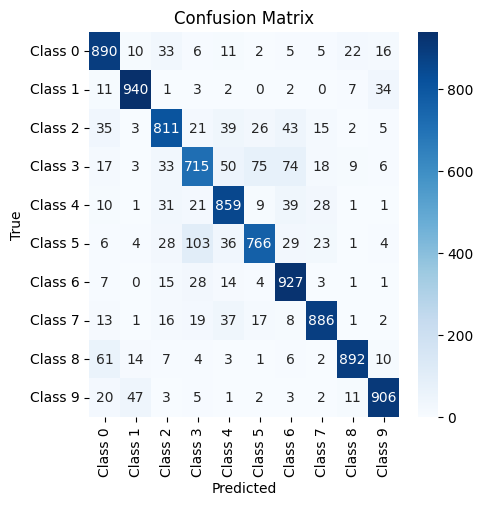

Test Accuracy: 85.92%


In [32]:
# Define albumentations transformations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.RandomResizedCrop(32, 32, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize to [-1, 1]
])
# Load CIFAR-10 dataset with albumentations transformations
trainset = CIFAR10(root='./data', train=True, download=True, transform=None)
trainset.transform = lambda img: transform(image=np.array(img))['image']


# Split dataset into train and validation
val_split = 0.2
train_size = len(trainset)
indices = list(range(train_size))
split = int(np.floor(val_split * train_size))
np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

train_subset = Subset(trainset, train_idx)
val_subset = Subset(trainset, val_idx)

# Instantiate ResNet model
resnet_nopooling = ResNetEncoder(BasicBlock, [1,1,1,1], num_classes=10, use_global_pooling=False)

# Train the model
training_results_nopooling = resnet_nopooling.train_model(train_subset, val_subset, learning_rate=0.001, batch_size=32, epochs=30)

# Test the model
testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_results_nopooling = resnet_nopooling.test_model(testset, batch_size=32)

# Print test accuracy
print(f"Test Accuracy: {test_results_nopooling['test_accuracy'][0]:.2f}%")

In [23]:
resnet = ResNetEncoder(BasicBlock, [1,1,1,1], num_classes=10, use_global_pooling=True)
summary(resnet, (3,32,32), 32, 'cpu') 

torch.Size([2, 64, 32, 32])
torch.Size([2, 3, 32, 32])
torch.Size([2, 128, 16, 16])
torch.Size([2, 64, 32, 32])
torch.Size([2, 256, 8, 8])
torch.Size([2, 128, 16, 16])
torch.Size([2, 512, 4, 4])
torch.Size([2, 256, 8, 8])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,728
       BatchNorm2d-2           [32, 64, 32, 32]             128
              ReLU-3           [32, 64, 32, 32]               0
            Conv2d-4           [32, 64, 32, 32]          36,864
       BatchNorm2d-5           [32, 64, 32, 32]             128
              ReLU-6           [32, 64, 32, 32]               0
        BasicBlock-7           [32, 64, 32, 32]               0
            Conv2d-8          [32, 128, 16, 16]          73,728
       BatchNorm2d-9          [32, 128, 16, 16]             256
             ReLU-10          [32, 128, 16, 16]               0
         

In [28]:
resnet_nopooling = ResNetEncoder(BasicBlock, [1,1,1,1], num_classes=10, use_global_pooling=False)

summary(resnet_nopooling, (3,32,32), 32, 'cpu') 

torch.Size([2, 64, 32, 32])
torch.Size([2, 3, 32, 32])
torch.Size([2, 128, 16, 16])
torch.Size([2, 64, 32, 32])
torch.Size([2, 256, 8, 8])
torch.Size([2, 128, 16, 16])
torch.Size([2, 512, 4, 4])
torch.Size([2, 256, 8, 8])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,728
       BatchNorm2d-2           [32, 64, 32, 32]             128
              ReLU-3           [32, 64, 32, 32]               0
            Conv2d-4           [32, 64, 32, 32]          36,864
       BatchNorm2d-5           [32, 64, 32, 32]             128
            Conv2d-6           [32, 64, 32, 32]             192
       BatchNorm2d-7           [32, 64, 32, 32]             128
              ReLU-8           [32, 64, 32, 32]               0
        BasicBlock-9           [32, 64, 32, 32]               0
           Conv2d-10          [32, 128, 16, 16]          73,728
      Bat

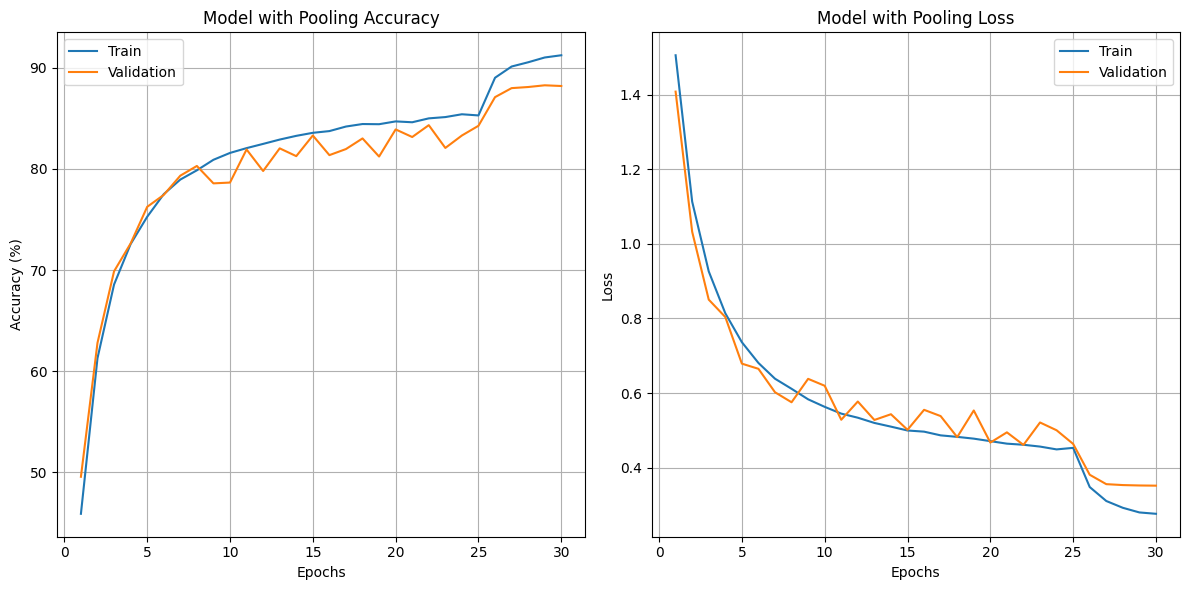

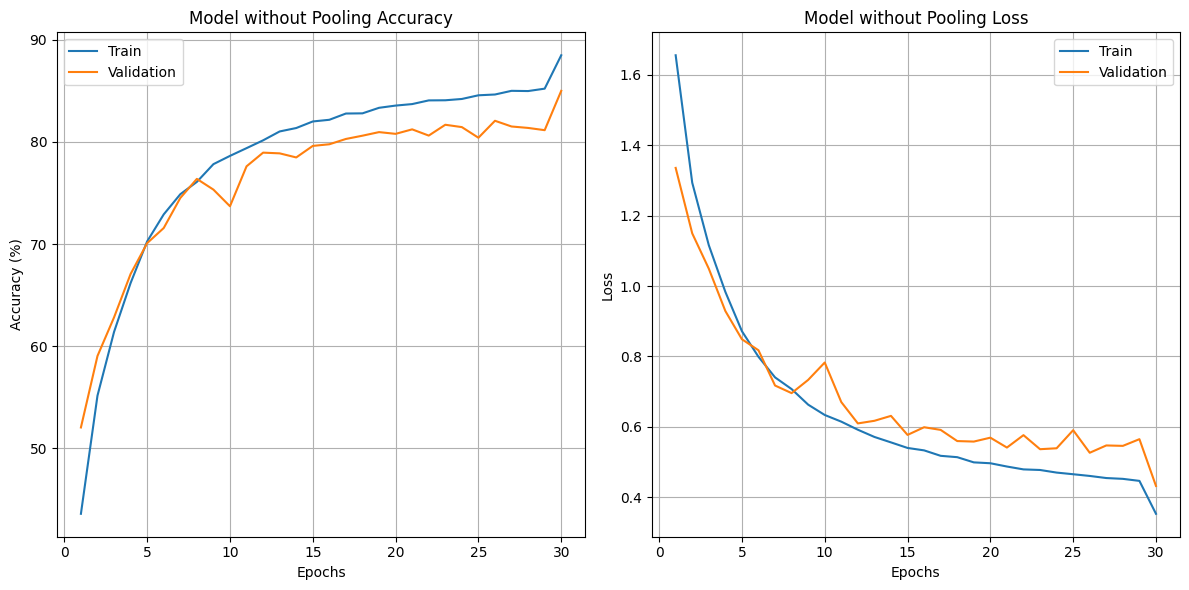

In [33]:
import matplotlib.pyplot as plt

def plot_training_history(training_results, title):
    epochs = len(training_results['train_accuracy'])
    plt.figure(figsize=(12, 6))

    # Plotting training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), training_results['train_accuracy'], label='Train')
    plt.plot(range(1, epochs + 1), training_results['val_accuracy'], label='Validation')
    plt.title(title + ' Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), training_results['train_loss'], label='Train')
    plt.plot(range(1, epochs + 1), training_results['val_loss'], label='Validation')
    plt.title(title + ' Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot evaluation metrics for model with global pooling
plot_training_history(training_results, 'Model with Pooling')

# Plot evaluation metrics for model without pooling
plot_training_history(training_results_nopooling, 'Model without Pooling')


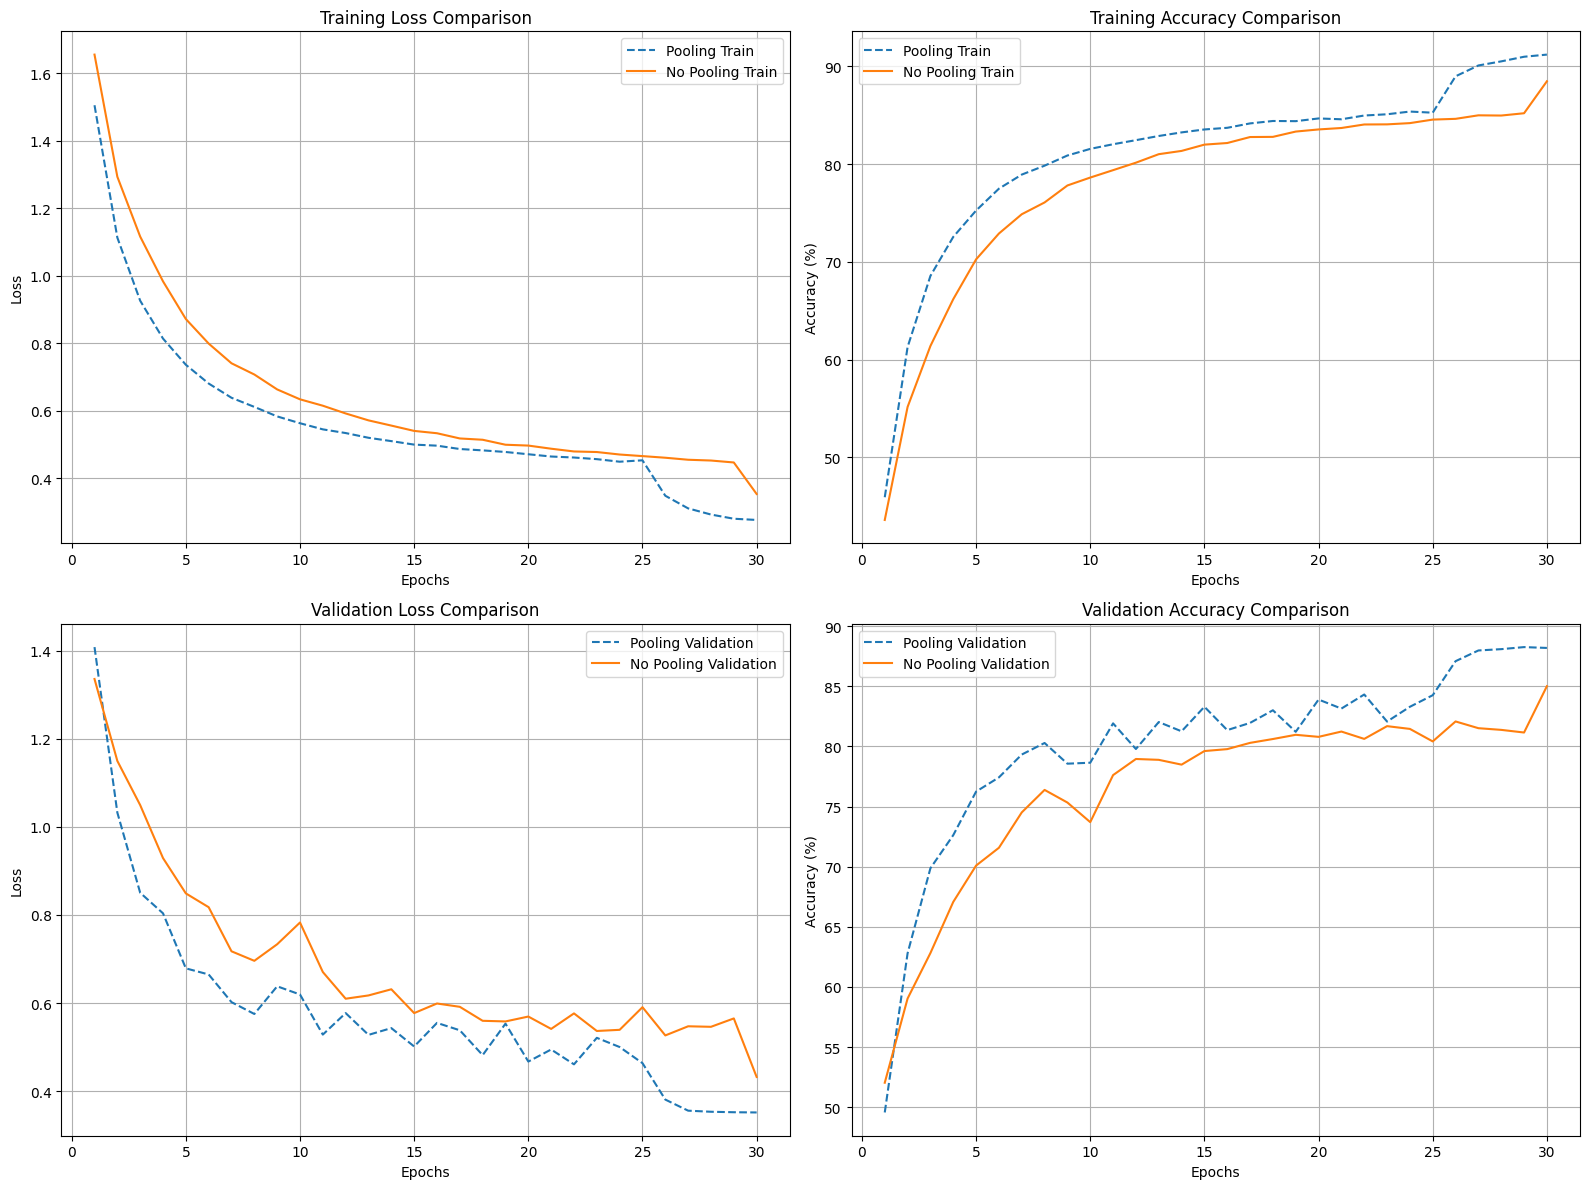

In [35]:
import matplotlib.pyplot as plt

def plot_comparison_four(training_results_pooling, training_results_nopooling):
    epochs_pooling = len(training_results_pooling['train_accuracy'])
    epochs_nopooling = len(training_results_nopooling['train_accuracy'])
    
    plt.figure(figsize=(16, 12))

    # Plotting training loss comparison
    plt.subplot(2, 2, 1)
    plt.plot(range(1, epochs_pooling + 1), training_results_pooling['train_loss'], label='Pooling Train', linestyle='--')
    plt.plot(range(1, epochs_nopooling + 1), training_results_nopooling['train_loss'], label='No Pooling Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plotting training accuracy comparison
    plt.subplot(2, 2, 2)
    plt.plot(range(1, epochs_pooling + 1), training_results_pooling['train_accuracy'], label='Pooling Train', linestyle='--')
    plt.plot(range(1, epochs_nopooling + 1), training_results_nopooling['train_accuracy'], label='No Pooling Train')
    plt.title('Training Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Plotting validation loss comparison
    plt.subplot(2, 2, 3)
    plt.plot(range(1, epochs_pooling + 1), training_results_pooling['val_loss'], label='Pooling Validation', linestyle='--')
    plt.plot(range(1, epochs_nopooling + 1), training_results_nopooling['val_loss'], label='No Pooling Validation')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plotting validation accuracy comparison
    plt.subplot(2, 2, 4)
    plt.plot(range(1, epochs_pooling + 1), training_results_pooling['val_accuracy'], label='Pooling Validation', linestyle='--')
    plt.plot(range(1, epochs_nopooling + 1), training_results_nopooling['val_accuracy'], label='No Pooling Validation')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot comparison between model with pooling and model without pooling
plot_comparison_four(training_results, training_results_nopooling)
